In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.metrics import confusion_matrix

from gensim.models import Word2Vec

In [2]:
raw_data = pd.read_csv("tripadvisor_hotel_reviews.csv")

In [3]:
raw_data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


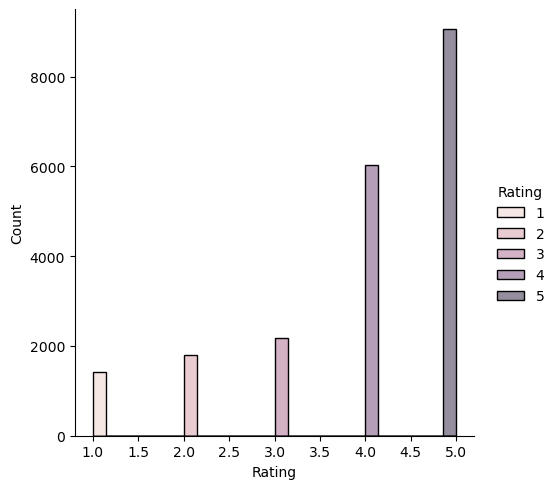

In [5]:
sns.displot(raw_data, x=raw_data.Rating, hue = "Rating", kind='hist', kde = True)

### 3 class claffification

In [6]:
def mark_sentiment(rating: int) -> int:
    if rating >=4 and rating <=5:
        return 2
    elif rating == 3:
        return 1
    else:
        return 0

In [7]:
raw_data["Sentiment"] = raw_data["Rating"].apply(mark_sentiment)

In [8]:
label_weights = raw_data["Sentiment"].value_counts(normalize=True)
label_weights

2    0.736567
0    0.156849
1    0.106583
Name: Sentiment, dtype: float64

In [9]:
label_weights_dict = dict(sorted(label_weights.items()))
label_weights_dict

{0: 0.15684934849446097, 1: 0.10658337806842028, 2: 0.7365672734371187}

#### Proprocessing data

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_text_data(data: pd.DataFrame):
  return data.apply(preprocess_text)

def preprocess_text(text: str):
  tokenized_sentence = word_tokenize(text)

  # converts the words in word_tokens to lower case and then checks whether
  #they are present in stop_words or not
  filtered_sentence = [w for w in tokenized_sentence if not w.lower() in stop_words]
  filtered_sentence = [lemmatizer.lemmatize(word=w) for w in filtered_sentence]
  filtered_sentence = [word.lower() for word in filtered_sentence]
  return filtered_sentence

In [12]:
processed_data = preprocess_text_data(raw_data["Review"])

In [13]:
n_features = 200

In [14]:
model = Word2Vec(processed_data, vector_size=n_features, window=100, min_count=1, workers=4)

In [15]:
def words2MeanVector(words: list[str]) -> np.ndarray:
    word_matrix = [model.wv[word] for word in words if word in model.wv]
    word_matrix = np.array(word_matrix)
    return np.mean(word_matrix, axis = 0)

In [16]:
vectorized_data = processed_data.apply(words2MeanVector)

In [17]:
# Define custom dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
Data_vectorized = pd.DataFrame(zip(vectorized_data, raw_data["Sentiment"]), columns = ["Review", "Sentiment"])

In [19]:
Train = Data_vectorized.sample(frac = 0.75, random_state = 42).reset_index(drop = True)
Test = Data_vectorized.drop(Train.index).sample(frac = 1).reset_index(drop = True)
X_train, y_train = Train["Review"], Train["Sentiment"]
X_test, y_test = Test["Review"], Test["Sentiment"]

In [20]:
# Create DataLoader for training and test sets
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### Training models

In [21]:
# Define softmax model
class SoftmaxModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxModel, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [46]:
# Define neural network model
class NNSoftmaxModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NNSoftmaxModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(200, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

In [23]:
def trainModel(train_loader: DataLoader, model: nn.Module, criterion: nn, optimizer: torch.optim, n_epochs: int) -> tuple[list[float], list[float], torch.Tensor, torch.Tensor]:
    losses = []
    accuracies = []

    train_predictions = torch.empty(0)
    train_truths = torch.empty(0)

    # Training loop
    for epoch in range(n_epochs):
        running_loss = 0.0

        correct = 0
        total = 0

        train_truths = torch.empty(0)
        train_predictions = torch.empty(0)

        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #Save results of batch
            train_truths = torch.cat((train_truths, labels), dim=0)
            train_predictions = torch.cat((train_predictions, predicted), dim=0)

        
        # Print statistics
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * (correct / total):.5}%")
        
        losses.append(running_loss/len(train_loader))
        accuracies.append(100 * correct / total)

    return losses, accuracies, train_predictions, train_truths
    

In [24]:
def testModel(test_loader: DataLoader, model: nn.Module) -> tuple[float, torch.Tensor, torch.Tensor]:
    test_predictions = torch.empty(0)
    test_truths = torch.empty(0)
    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_predictions = torch.cat((test_predictions, predicted), dim=0)
            test_truths = torch.cat((test_truths, labels), dim=0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy, test_predictions, test_truths

In [25]:
# Initialize model, loss function, and optimizer
modelSoftMax = SoftmaxModel(input_size=n_features, num_classes=3)
criterionSoftMax = nn.CrossEntropyLoss(weight=torch.Tensor(list(label_weights_dict.values())))
optimizerSoftMax = torch.optim.Adam(modelSoftMax.parameters(), lr=0.001)

In [47]:
modelNN = NNSoftmaxModel(input_size=n_features, num_classes=3)
criterionNN = nn.CrossEntropyLoss(weight=torch.Tensor(list(label_weights_dict.values())))
optimizerNN = torch.optim.Adam(modelNN.parameters(), lr=0.001)

In [27]:
lossesSoft, accuraciesSoft, predictions, truths = trainModel(train_loader, modelSoftMax, criterionSoftMax, optimizerSoftMax, 100)

Epoch [1/100], Loss: 0.2752, Accuracy: 73.861%
Epoch [2/100], Loss: 0.1826, Accuracy: 77.063%
Epoch [3/100], Loss: 0.1651, Accuracy: 79.607%
Epoch [4/100], Loss: 0.1577, Accuracy: 80.492%
Epoch [5/100], Loss: 0.1531, Accuracy: 81.195%
Epoch [6/100], Loss: 0.1495, Accuracy: 81.514%
Epoch [7/100], Loss: 0.1485, Accuracy: 81.787%
Epoch [8/100], Loss: 0.1466, Accuracy: 81.923%
Epoch [9/100], Loss: 0.1456, Accuracy: 82.19%
Epoch [10/100], Loss: 0.1447, Accuracy: 82.275%
Epoch [11/100], Loss: 0.1436, Accuracy: 82.385%
Epoch [12/100], Loss: 0.1446, Accuracy: 82.535%
Epoch [13/100], Loss: 0.1432, Accuracy: 82.522%
Epoch [14/100], Loss: 0.1420, Accuracy: 82.685%
Epoch [15/100], Loss: 0.1431, Accuracy: 82.743%
Epoch [16/100], Loss: 0.1416, Accuracy: 82.587%
Epoch [17/100], Loss: 0.1459, Accuracy: 82.802%
Epoch [18/100], Loss: 0.1420, Accuracy: 82.86%
Epoch [19/100], Loss: 0.1416, Accuracy: 82.926%
Epoch [20/100], Loss: 0.1430, Accuracy: 82.913%
Epoch [21/100], Loss: 0.1438, Accuracy: 82.971%
Epo

In [48]:
lossesNN, accuraciesNN, predictionsNN, truthsNN = trainModel(train_loader, modelNN, criterionNN, optimizerNN, 100)

Epoch [1/100], Loss: 0.2220, Accuracy: 77.922%
Epoch [2/100], Loss: 0.1529, Accuracy: 82.841%
Epoch [3/100], Loss: 0.1439, Accuracy: 82.782%
Epoch [4/100], Loss: 0.1399, Accuracy: 83.147%
Epoch [5/100], Loss: 0.1396, Accuracy: 83.231%
Epoch [6/100], Loss: 0.1377, Accuracy: 83.42%
Epoch [7/100], Loss: 0.1375, Accuracy: 83.433%
Epoch [8/100], Loss: 0.1351, Accuracy: 83.355%
Epoch [9/100], Loss: 0.1360, Accuracy: 83.524%
Epoch [10/100], Loss: 0.1333, Accuracy: 83.667%
Epoch [11/100], Loss: 0.1313, Accuracy: 83.68%
Epoch [12/100], Loss: 0.1328, Accuracy: 83.726%
Epoch [13/100], Loss: 0.1293, Accuracy: 84.058%
Epoch [14/100], Loss: 0.1290, Accuracy: 83.863%
Epoch [15/100], Loss: 0.1316, Accuracy: 83.693%
Epoch [16/100], Loss: 0.1302, Accuracy: 83.986%
Epoch [17/100], Loss: 0.1272, Accuracy: 84.142%
Epoch [18/100], Loss: 0.1262, Accuracy: 84.266%
Epoch [19/100], Loss: 0.1230, Accuracy: 84.461%
Epoch [20/100], Loss: 0.1219, Accuracy: 84.572%
Epoch [21/100], Loss: 0.1197, Accuracy: 84.832%
Epo

In [49]:
softMaxAccTest, softMaxPredsTest, softMaxTruthsTest = testModel(test_loader, modelSoftMax)
nnAccTest, nnPredsTest, nnTruthsTest = testModel(test_loader, modelNN)

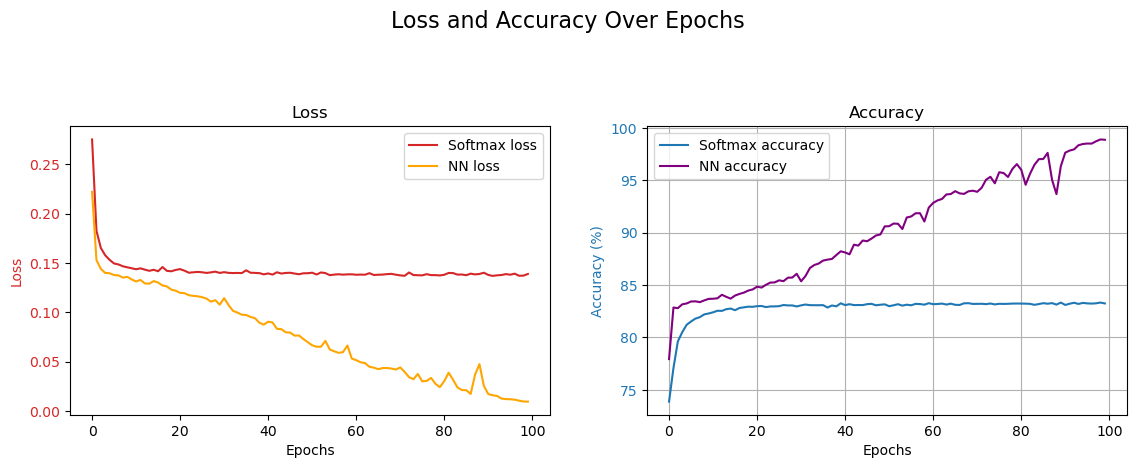

In [51]:
# Create figure and axis objects for losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss values for the first model
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(lossesSoft, color=color, label='Softmax loss')
ax1.plot(lossesNN, color='orange', label='NN loss')  # Assuming you have losses for the second model
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Loss")
ax1.legend()

# Plot accuracy values for the first model
color = 'tab:blue'
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)', color=color)  
ax2.plot(accuraciesSoft, color=color, label='Softmax accuracy')
ax2.plot(accuraciesNN, color='purple', label='NN accuracy')  # Assuming you have accuracies for the second model
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title("Accuracy")
ax2.legend()

# Title and show the plots
fig.suptitle('Loss and Accuracy Over Epochs', fontsize=16)
fig.tight_layout(pad=3.0)
plt.grid(True)
plt.show()

In [54]:
nnAccTest

0.9498340815928167

In [52]:
train_truth_list_softmax = torch.Tensor.tolist(truths)
train_prediction_list_softmax = torch.Tensor.tolist(predictions)
test_truth_list_softmax = torch.Tensor.tolist(softMaxTruthsTest)
test_prediction_list_softmax = torch.Tensor.tolist(softMaxPredsTest)

#-------------------------------------------------------------------------#

train_truth_list_nn = torch.Tensor.tolist(truthsNN)
train_prediction_list_nn = torch.Tensor.tolist(predictionsNN)
test_truth_list_nn = torch.Tensor.tolist(nnTruthsTest)
test_prediction_list_nn = torch.Tensor.tolist(nnPredsTest)

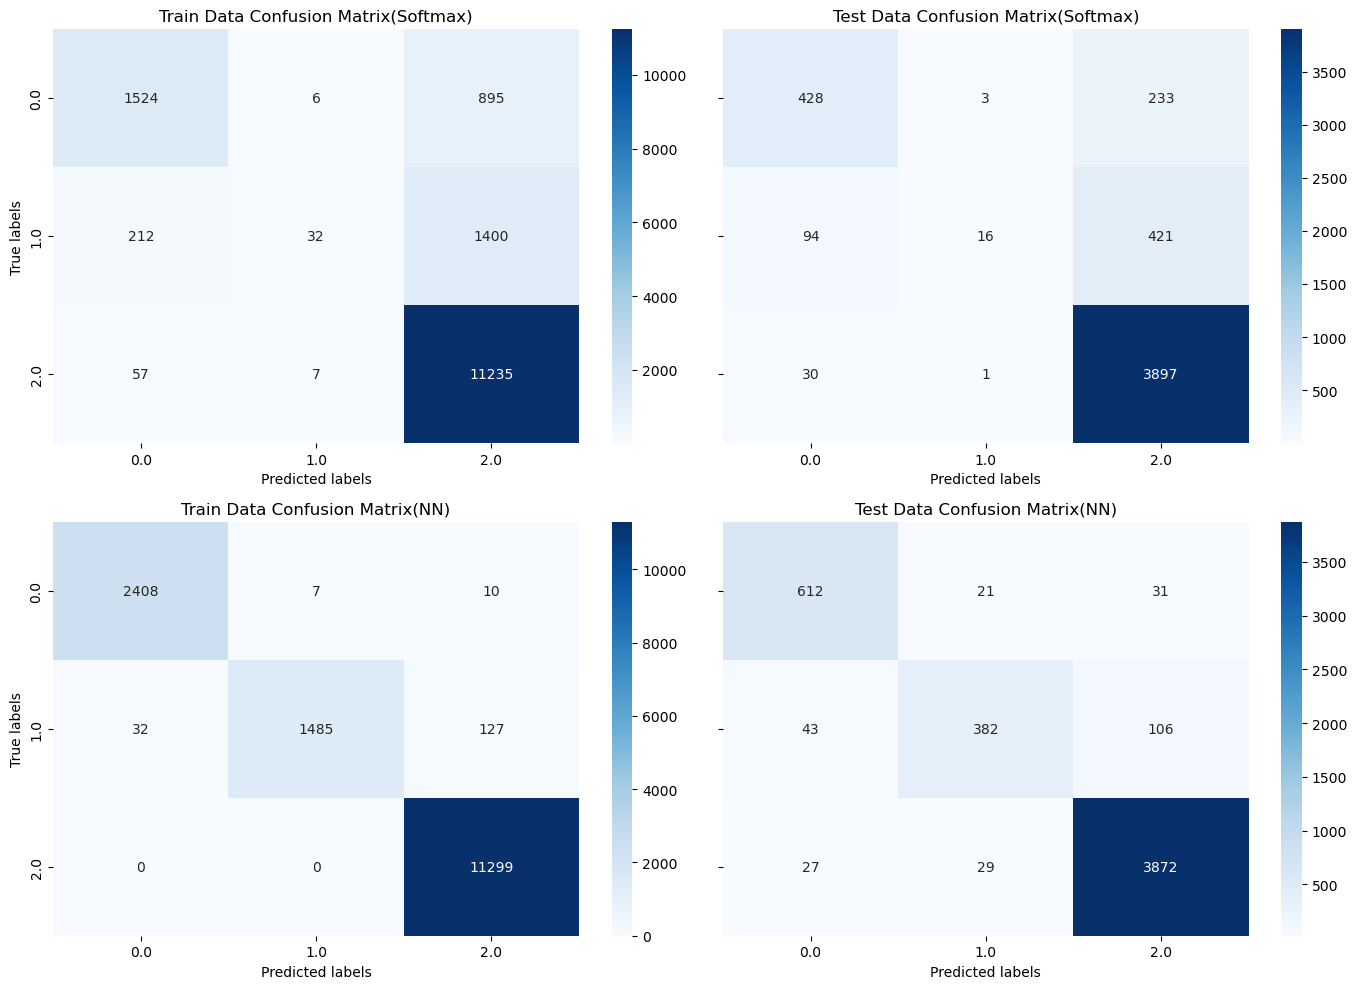

In [53]:
# Compute confusion matrices for train and test data
train_cm_softmax = confusion_matrix(train_truth_list_softmax, train_prediction_list_softmax)
test_cm_softmax = confusion_matrix(test_truth_list_softmax, test_prediction_list_softmax)

train_cm_nn = confusion_matrix(train_truth_list_nn, train_prediction_list_nn)
test_cm_nn = confusion_matrix(test_truth_list_nn, test_prediction_list_nn)

# Create subplots for train and test confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharey=True)

# Plot confusion matrix for train data
sns.heatmap(train_cm_softmax, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(train_prediction_list_softmax), 
            yticklabels=np.unique(train_truth_list_softmax), 
            ax=axes[0][0])
axes[0][0].set_title('Train Data Confusion Matrix(Softmax)')
axes[0][0].set_xlabel('Predicted labels')
axes[0][0].set_ylabel('True labels')

# Plot confusion matrix for test data
sns.heatmap(test_cm_softmax, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(test_prediction_list_softmax), 
            yticklabels=np.unique(test_truth_list_softmax), 
            ax=axes[0][1])
axes[0][1].set_title('Test Data Confusion Matrix(Softmax)')
axes[0][1].set_xlabel('Predicted labels')

# Plot confusion matrix for train data
sns.heatmap(train_cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(train_prediction_list_nn), 
            yticklabels=np.unique(train_truth_list_nn), 
            ax=axes[1][0])
axes[1][0].set_title('Train Data Confusion Matrix(NN)')
axes[1][0].set_xlabel('Predicted labels')
axes[1][0].set_ylabel('True labels')

# Plot confusion matrix for test data
sns.heatmap(test_cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(test_prediction_list_nn), 
            yticklabels=np.unique(test_truth_list_nn), 
            ax=axes[1][1])
axes[1][1].set_title('Test Data Confusion Matrix(NN)')
axes[1][1].set_xlabel('Predicted labels')

plt.tight_layout()
plt.show()